<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

import json
import time

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# Descargar el dataset
!gdown --id 1S8DaGqN_L6xeXpo2lG74ImD_fTAawQee

Downloading...
From: https://drive.google.com/uc?id=1S8DaGqN_L6xeXpo2lG74ImD_fTAawQee
To: /content/edSheraanSong.zip
100% 32.3k/32.3k [00:00<00:00, 26.7MB/s]


In [3]:
# Descomprimir el archivo descargado
!rm /content/edSheeranSong.json
!unzip /content/edSheraanSong.zip > /dev/null

rm: cannot remove '/content/edSheeranSong.json': No such file or directory


In [4]:
f = open("/content/edSheraanSong.json") # Opening JSON file
row_data = json.load(f)                # Returns JSON object as a dictionary
f.close()                               # Closing file

print("Cantidad de canciones: "+str(len(row_data)))
print(type(row_data[0]))
print(row_data[0])
print(row_data[15])

Cantidad de canciones: 61
<class 'dict'>
{'lyrics': "The club isn't the best place to find a lover\nSo the bar is where I go\nMe and my friends at the table doing shots\nDrinking faster and then we talk slow\nCome over and start up a conversation with just me\nAnd trust me I'll give it a chance now\nTake my hand, stop\nPut Van The Man on the jukebox\nAnd then we start to dance\nAnd now I'm singing like\n\nGirl, you know I want your love\nYour love was handmade for somebody like me\nCome on now, follow my lead\nI may be crazy, don't mind me\nSay, boy, let's not talk too much\nGrab on my waist and put that body on me\nCome on now, follow my lead\nCome, come on now, follow my lead\n\nI'm in love with the shape of you\nWe push and pull like a magnet do\nAlthough my heart is falling too\nI'm in love with your body\nAnd last night you were in my room\nAnd now my bedsheets smell like you\nEvery day discovering something brand new\nI'm in love with your body\nOh—i—oh—i—oh—i—oh—i\nI'm in love w

In [5]:
# Mostrar las letras de las canciones
# for l in row_data:
#  print(l['lyrics'])

In [6]:
# Armar lista con letras
lyrics_list = []
for l in row_data:
  lyrics_list.append(l['lyrics'])

# Juntar todo en un string, separado por saltos del inea
lyrics="\n".join(lyrics_list)
print(type(lyrics))
print(len(lyrics))

<class 'str'>
116140


In [7]:
lyrics

'The club isn\'t the best place to find a lover\nSo the bar is where I go\nMe and my friends at the table doing shots\nDrinking faster and then we talk slow\nCome over and start up a conversation with just me\nAnd trust me I\'ll give it a chance now\nTake my hand, stop\nPut Van The Man on the jukebox\nAnd then we start to dance\nAnd now I\'m singing like\n\nGirl, you know I want your love\nYour love was handmade for somebody like me\nCome on now, follow my lead\nI may be crazy, don\'t mind me\nSay, boy, let\'s not talk too much\nGrab on my waist and put that body on me\nCome on now, follow my lead\nCome, come on now, follow my lead\n\nI\'m in love with the shape of you\nWe push and pull like a magnet do\nAlthough my heart is falling too\nI\'m in love with your body\nAnd last night you were in my room\nAnd now my bedsheets smell like you\nEvery day discovering something brand new\nI\'m in love with your body\nOh—i—oh—i—oh—i—oh—i\nI\'m in love with your body\nOh—i—oh—i—oh—i—oh—i\nI\'m in

In [8]:
while lyrics.find("\n\n") >= 0:
  lyrics = lyrics.replace("\n\n","\n")
  print(lyrics)

data = lyrics.split("\n")
print(data)

The club isn't the best place to find a lover
So the bar is where I go
Me and my friends at the table doing shots
Drinking faster and then we talk slow
Come over and start up a conversation with just me
And trust me I'll give it a chance now
Take my hand, stop
Put Van The Man on the jukebox
And then we start to dance
And now I'm singing like
Girl, you know I want your love
Your love was handmade for somebody like me
Come on now, follow my lead
I may be crazy, don't mind me
Say, boy, let's not talk too much
Grab on my waist and put that body on me
Come on now, follow my lead
Come, come on now, follow my lead
I'm in love with the shape of you
We push and pull like a magnet do
Although my heart is falling too
I'm in love with your body
And last night you were in my room
And now my bedsheets smell like you
Every day discovering something brand new
I'm in love with your body
Oh—i—oh—i—oh—i—oh—i
I'm in love with your body
Oh—i—oh—i—oh—i—oh—i
I'm in love with your body
Oh—i—oh—i—oh—i—oh—i
I'm

In [9]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.DataFrame(data)
df.head()

,0
0,The club isn't the best place to find a lover
1,So the bar is where I go
2,Me and my friends at the table doing shots
3,Drinking faster and then we talk slow
4,Come over and start up a conversation with jus...


In [10]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3253


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [11]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [12]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[0,0]
text

"The club isn't the best place to find a lover"

In [13]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['the', 'club', "isn't", 'the', 'best', 'place', 'to', 'find', 'a', 'lover']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [14]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [15]:
# Demos un vistazo
sentence_tokens[:2]

[['the', 'club', "isn't", 'the', 'best', 'place', 'to', 'find', 'a', 'lover'],
 ['so', 'the', 'bar', 'is', 'where', 'i', 'go']]

In [16]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [17]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:10]

[['the', 'club', "isn't", 'the'],
 ['club', "isn't", 'the', 'best'],
 ["isn't", 'the', 'best', 'place'],
 ['the', 'best', 'place', 'to'],
 ['best', 'place', 'to', 'find'],
 ['place', 'to', 'find', 'a']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [18]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [19]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[1, 6, 4, 1],
 [6, 4, 1, 2],
 [4, 1, 2, 3],
 [1, 2, 3, 5],
 [2, 3, 5, 7],
 [3, 5, 7, 8]]

In [20]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

6


In [21]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

8


In [22]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'best': 2, 'place': 3, "isn't": 4, 'to': 5, 'club': 6, 'find': 7, 'a': 8}


In [23]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'club': 2, "isn't": 3, 'the': 4, 'best': 4, 'place': 4, 'to': 3, 'find': 2, 'a': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [24]:
# Vistazo a las primeras filas
df.loc[:15,0]

0         The club isn't the best place to find a lover
1                              So the bar is where I go
2            Me and my friends at the table doing shots
3                 Drinking faster and then we talk slow
4     Come over and start up a conversation with jus...
5                And trust me I'll give it a chance now
6                                    Take my hand, stop
7                        Put Van The Man on the jukebox
8                            And then we start to dance
9                              And now I'm singing like
10                      Girl, you know I want your love
11          Your love was handmade for somebody like me
12                          Come on now, follow my lead
13                        I may be crazy, don't mind me
14                    Say, boy, let's not talk too much
15             Grab on my waist and put that body on me
Name: 0, dtype: object

In [25]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'The club isn\'t the best place to find a lover So the bar is where I go Me and my friends at the table doing shots Drinking faster and then we talk slow Come over and start up a conversation with just me And trust me I\'ll give it a chance now Take my hand, stop Put Van The Man on the jukebox And then we start to dance And now I\'m singing like Girl, you know I want your love Your love was handmade for somebody like me Come on now, follow my lead I may be crazy, don\'t mind me Say, boy, let\'s not talk too much Grab on my waist and put that body on me Come on now, follow my lead Come, come on now, follow my lead I\'m in love with the shape of you We push and pull like a magnet do Although my heart is falling too I\'m in love with your body And last night you were in my room And now my bedsheets smell like you Every day discovering something brand new I\'m in love with your body Oh—i—oh—i—oh—i—oh—i I\'m in love with your body Oh—i—oh—i—oh—i—oh—i I\'m in love with your body Oh—i—oh—i—oh

In [26]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['the',
 'club',
 "isn't",
 'the',
 'best',
 'place',
 'to',
 'find',
 'a',
 'lover',
 'so',
 'the',
 'bar',
 'is',
 'where',
 'i',
 'go',
 'me',
 'and',
 'my']

In [27]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 23761


In [28]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [29]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['the', 'club', "isn't", 'the'],
 ['club', "isn't", 'the', 'best'],
 ["isn't", 'the', 'best', 'place'],
 ['the', 'best', 'place', 'to'],
 ['best', 'place', 'to', 'find'],
 ['place', 'to', 'find', 'a'],
 ['to', 'find', 'a', 'lover'],
 ['find', 'a', 'lover', 'so'],
 ['a', 'lover', 'so', 'the'],
 ['lover', 'so', 'the', 'bar'],
 ['so', 'the', 'bar', 'is'],
 ['the', 'bar', 'is', 'where'],
 ['bar', 'is', 'where', 'i'],
 ['is', 'where', 'i', 'go'],
 ['where', 'i', 'go', 'me'],
 ['i', 'go', 'me', 'and'],
 ['go', 'me', 'and', 'my'],
 ['me', 'and', 'my', 'friends'],
 ['and', 'my', 'friends', 'at'],
 ['my', 'friends', 'at', 'the']]

In [30]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[3, 938, 937, 3],
 [938, 937, 3, 318],
 [937, 3, 318, 240],
 [3, 318, 240, 7],
 [318, 240, 7, 151],
 [240, 7, 151, 10],
 [7, 151, 10, 112],
 [151, 10, 112, 26],
 [10, 112, 26, 3],
 [112, 26, 3, 425],
 [26, 3, 425, 37],
 [3, 425, 37, 122],
 [425, 37, 122, 1],
 [37, 122, 1, 44],
 [122, 1, 44, 6],
 [1, 44, 6, 5],
 [44, 6, 5, 4],
 [6, 5, 4, 101],
 [5, 4, 101, 89],
 [4, 101, 89, 3]]

In [31]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 23757


### 3 - Input y target

In [32]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [33]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [34]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [35]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(23757, 3)
(23757,)


In [36]:
# Palabras del vocabulario
tok.index_word

{1: 'i',
 2: 'you',
 3: 'the',
 4: 'my',
 5: 'and',
 6: 'me',
 7: 'to',
 8: 'in',
 9: 'love',
 10: 'a',
 11: 'on',
 12: 'your',
 13: 'it',
 14: 'that',
 15: 'of',
 16: 'be',
 17: "i'm",
 18: 'but',
 19: 'with',
 20: 'all',
 21: 'know',
 22: 'just',
 23: 'we',
 24: 'for',
 25: "don't",
 26: 'so',
 27: 'now',
 28: 'if',
 29: 'up',
 30: 'like',
 31: 'baby',
 32: 'come',
 33: 'out',
 34: "i'll",
 35: 'when',
 36: 'this',
 37: 'is',
 38: 'oh',
 39: 'was',
 40: 'one',
 41: "you're",
 42: 'can',
 43: 'never',
 44: 'go',
 45: 'wanna',
 46: 'are',
 47: "it's",
 48: 'time',
 49: 'as',
 50: 'way',
 51: 'give',
 52: "i've",
 53: 'back',
 54: 'should',
 55: 'take',
 56: 'could',
 57: 'want',
 58: 'only',
 59: 'will',
 60: 'not',
 61: 'do',
 62: 'down',
 63: 'no',
 64: 'feel',
 65: 'home',
 66: 'make',
 67: 'she',
 68: 'from',
 69: 'let',
 70: 'see',
 71: 'ye',
 72: 'then',
 73: 'been',
 74: 'heart',
 75: 'how',
 76: 'still',
 77: 'right',
 78: 'got',
 79: 'long',
 80: 'life',
 81: 'her',
 82: 'say'

In [37]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2272

In [38]:
# Transformar los datos a oneHotEncoding
# y_data = to_categorical(y_data_int, num_classes=vocab_size) # Tira error porque los index arrancan en 1

# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [39]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(23757, 2272)

### 4 - Entrenar el modelo

In [40]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [41]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

2272

In [42]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              11365     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 64)             33024     
                                                                 
 dropout_1 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2

In [43]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
594/594 [==============================] - 23s 15ms/step - loss: 6.2363 - accuracy: 0.0318 - val_loss: 6.4437 - val_accuracy: 0.0253
Epoch 2/50
594/594 [==============================] - 8s 13ms/step - loss: 5.9044 - accuracy: 0.0370 - val_loss: 6.4897 - val_accuracy: 0.0244
Epoch 3/50
594/594 [==============================] - 8s 13ms/step - loss: 5.8453 - accuracy: 0.0395 - val_loss: 6.5283 - val_accuracy: 0.0259
Epoch 4/50
594/594 [==============================] - 8s 13ms/step - loss: 5.7722 - accuracy: 0.0391 - val_loss: 6.5088 - val_accuracy: 0.0324
Epoch 5/50
594/594 [==============================] - 8s 14ms/step - loss: 5.6718 - accuracy: 0.0388 - val_loss: 6.5729 - val_accuracy: 0.0318
Epoch 6/50
594/594 [==============================] - 8s 13ms/step - loss: 5.6058 - accuracy: 0.0385 - val_loss: 6.6246 - val_accuracy: 0.0324
Epoch 7/50
594/594 [==============================] - 8s 13ms/step - loss: 5.5516 - accuracy: 0.0429 - val_loss: 6.7780 - val_accuracy: 0.040

In [49]:
# Guardarlo en un archivo pickle
file_name = "predict_model" + str(time.time()).split(".")[0] + ".pickle"
with open(file_name, 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: ram://9ed782cb-5784-4b1e-ab4f-f5fcadba738b/assets


INFO:tensorflow:Assets written to: ram://9ed782cb-5784-4b1e-ab4f-f5fcadba738b/assets


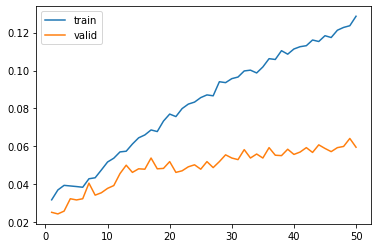

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [47]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [50]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
     |████████████████████████████████| 84 kB 2.7 MB/s 
     |████████████████████████████████| 1.1 MB 35.8 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 211 kB 43.1 MB/s 
     |████████████████████████████████| 2.0 MB 37.5 MB/s 
     |████████████████████████████████| 255 kB 51.6 MB/s 
     |████████████████████████████████| 271 kB 49.2 MB/s 
ERROR: Operation cancelled by user


In [53]:
!pip install gradio

  Using cached gradio-2.9.1-py3-none-any.whl (1.7 MB)
  Using cached orjson-3.6.7-cp37-cp37m-manylinux_2_24_x86_64.whl (255 kB)
  Using cached ffmpy-0.3.0.tar.gz (4.8 kB)
  Using cached aiohttp-3.8.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached markdown_it_py-2.0.1-py3-none-any.whl (84 kB)
  Using cached paramiko-2.10.3-py2.py3-none-any.whl (211 kB)
  Using cached fastapi-0.75.1-py3-none-any.whl (54 kB)
  Using cached pycryptodome-3.14.1-cp35-abi3-manylinux2010_x86_64.whl (2.0 MB)
  Using cached uvicorn-0.17.6-py3-none-any.whl (53 kB)
  Using cached python-multipart-0.0.5.tar.gz (32 kB)
  Using cached analytics_python-1.4.0-py2.py3-none-any.whl (15 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached yarl-1.7.2-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (271 kB)
  Using cached aiosignal-1.2.0-py3-none-any.whl (8.2 kB)
     |███████████

In [54]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://23248.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f65759ec610>,
 'http://127.0.0.1:7860/',
 'https://23248.gradio.app')

### 6 - Generación de secuencias nuevas

In [55]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [56]:
input_text='hey jude don\'t'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

"hey jude don't have my"

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.